# Data z tramvají DPO
### Zkoumání pro korelaci s realitou

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import tconsumption
from tramparse import tram_csv_parser, make_geojson
import matplotlib.pyplot as plt
from scipy.signal import hilbert, argrelextrema
import ruptures as rpt
import importlib
import os

In [2]:
DATA_PATH="../../enet-sz-data/real_rides/"
df = tram_csv_parser(DATA_PATH + "DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.csv")

In [3]:
df_important = df[[
    "DateTime", "delta_T", "VrGpsLatitude", "VrGpsLongitude",
    "km_total", "tm_rychlost_3_napravy", "tm2_rychlost_5_napravy",
    "cela_vykon_spotrebovany_bez_spotrebicu", "cela_vykon_rekuperovany_bez_spotrebicu",
    "cela_energie_spotrebovana_bez_spotrebicu", "cela_energie_rekuperovana_bez_spotrebicu"
]]

df_important["cela_vykon_vyrovnany_bez_spotrebicu"] = df_important["cela_vykon_spotrebovany_bez_spotrebicu"]-df_important["cela_vykon_rekuperovany_bez_spotrebicu"]
df_important["cela_energie_vyrovnana_bez_spotrebicu"] = df_important["cela_energie_spotrebovana_bez_spotrebicu"]-df_important["cela_energie_rekuperovana_bez_spotrebicu"]

geojson = make_geojson(df_important["VrGpsLatitude"],df_important["VrGpsLongitude"])
with open("/tmp/test.geojson", "w") as f:
    f.write(geojson)

/tmp/ipykernel_87438/3941359690.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important["cela_vykon_vyrovnany_bez_spotrebicu"] = df_important["cela_vykon_spotrebovany_bez_spotrebicu"]-df_important["cela_vykon_rekuperovany_bez_spotrebicu"]
/tmp/ipykernel_87438/3941359690.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important["cela_energie_vyrovnana_bez_spotrebicu"] = df_important["cela_energie_spotrebovana_bez_spotrebicu"]-df_important["cela_energie_rekuperovana_bez_spotrebicu"]


<Axes: xlabel='km_total'>

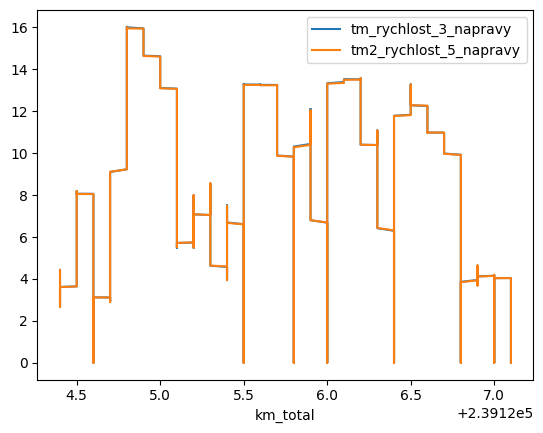

In [4]:
df_important.plot(x="km_total", y=["tm_rychlost_3_napravy", "tm2_rychlost_5_napravy"])

In [5]:
df_important.head()

,DateTime,delta_T,VrGpsLatitude,VrGpsLongitude,km_total,tm_rychlost_3_napravy,tm2_rychlost_5_napravy,cela_vykon_spotrebovany_bez_spotrebicu,cela_vykon_rekuperovany_bez_spotrebicu,cela_energie_spotrebovana_bez_spotrebicu,cela_energie_rekuperovana_bez_spotrebicu,cela_vykon_vyrovnany_bez_spotrebicu,cela_energie_vyrovnana_bez_spotrebicu
0,2022-04-20 08:54:54.184,0 days 00:00:00.100000,49.83483,18.17648,239124.4,4.431147,4.422394,5.10375,0.00000,0.000000,0.000000,5.10375,0.000000
1,2022-04-20 08:54:54.284,0 days 00:00:00.099000,49.83483,18.17648,239124.4,4.431147,4.428036,4.81806,0.00000,0.000142,0.000000,4.81806,0.000142
2,2022-04-20 08:54:54.383,0 days 00:00:00.101000,49.83483,18.17648,239124.4,4.425467,4.419575,0.00000,13.73600,0.000274,0.000000,-13.73600,0.000274
3,2022-04-20 08:54:54.484,0 days 00:00:00.100000,49.83483,18.17648,239124.4,4.402742,4.405472,0.00000,37.26192,0.000274,0.000385,-37.26192,-0.000111
4,2022-04-20 08:54:54.584,0 days 00:00:00.100000,49.83483,18.17648,239124.4,4.380019,4.380089,0.00000,28.73187,0.000274,0.001420,-28.73187,-0.001146


In [6]:
velocity_segment_cache = {}

In [7]:
def compare_data(csv_path: str, geojson_path: str):
    # Data identification
    data_name = os.path.basename(geojson_path).split(".")[0]

    # Calculated data
    c = tconsumption.Consumption()
    c.params["mass_locomotive"] = 34500
    # c.variable_params["Recuperation coefficient"] = 0.38
    c.variable_params = {
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98,
        "Compensation polynomial": None
    }
    c.load_from_file(geojson_path)

    # Measured data
    df = tram_csv_parser(csv_path)

    # Modifying some parameters
    print("Graphs for data:", data_name)
    print("Max power from measured data:", df["cela_vykon_vyrovnany_bez_spotrebicu"].max())
    # c.params["power_limit"] = None
    c.params["power_limit"] = 600*1000
    # c.params["acceleration_limit"] = 1*G_TO_MS2

    # Inferring stops
    stations_stopped = []
    last_row_zero = 0
    for i,row in enumerate(df["tm_rychlost_3_napravy"]):
        if row < 1:
            if last_row_zero < i-1:
                stations_stopped.append(i)
            last_row_zero = i
    c.stations = [c.stations[0]] + stations_stopped + [c.stations[-1]]

    # Getting velocity segments
    if data_name not in velocity_segment_cache:
        algo = rpt.Pelt(model="rbf").fit(df["tm_rychlost_3_napravy"].values)
        result = algo.predict(pen=100)
        velocity_segment_cache[data_name] = result.copy()
    else:
        result = velocity_segment_cache[data_name].copy()

    to_remove = []
    for i,r in enumerate(result):
        if i == 0:
            continue
        slice = df["tm_rychlost_3_napravy"][result[i-1]:r]
        # if len(slice) < 100 or len(slice)/2 < len([x for x in slice if x <= 0]):
        if len(slice)/4 < len([x for x in slice if x <= 0]):
            to_remove.append(i-1)
    to_remove.reverse()
    for i in to_remove:
        del result[i]

    # fig, ax = plt.subplots()
    # fig.set_figwidth(20)
    # ax.plot(list(df["tm_rychlost_3_napravy"]), color="tab:red")
    # plt.title("Velocity change points")
    # for r in result:
    #     ax.axvline(x=r, color="k", linestyle="--")
    # plt.show()

    max_velocities = []
    for i,r in enumerate(result):
        if i == 0:
            segment = df["tm_rychlost_3_napravy"][:r]
        else:
            segment = df["tm_rychlost_3_napravy"][result[i-1]:r]
        max_velocities += [max(segment)] * len(segment)

    c.max_velocities_in_mps = max_velocities

    # Running the simulation
    c.run()

    # NOTE: Debugging, DELETE LATER
    # df = df.iloc[c.stations[5]:]

    # Plotting
    energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
    energy_real = df["cela_energie_vyrovnana_bez_spotrebicu"]
    print(f"Simulation final energy: {energy_calculated[-1]}")
    print(f"Real final energy: {energy_real.iloc[-1]}")

    plt.figure().set_figwidth(20)
    start_slice = 0
    plt.plot(c.series["dist_values"][start_slice:], energy_calculated[start_slice:])
    plt.plot(c.series["dist_values"][start_slice:], energy_real[start_slice:])
    plt.title("Energy")
    plt.legend(["Simulation", "Real"], loc ="upper right")
    plt.show()

    # NOTE: Deprecated
    # plt.figure().set_figwidth(20)
    # plt.plot(c.series["dist_values"], c.series["braking_at_the_end"])
    # plt.title("Braking at the end")
    # plt.show()

    # plt.figure().set_figwidth(20)
    # plt.plot(c.series["dist_values"], c.series["exerted_force_values"])
    # plt.title("Exerted force")
    # plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], [x[2] for x in c.points])
    plt.title("Elevation")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.series["velocity_values"])
    plt.plot(c.series["dist_values"], df["tm_rychlost_3_napravy"])
    plt.title("Velocity")
    plt.legend(["Simulation", "Real"], loc ="upper right")
    plt.show()

    # plt.figure().set_figwidth(20)
    # plt.scatter(c.series["dist_values"], c.series["velocity_values"])
    # plt.title("Calculated velocity")
    # plt.show()

    # plt.figure().set_figwidth(20)
    # plt.scatter(c.series["dist_values"], list(df["tm_rychlost_3_napravy"]))
    # plt.title("Real velocity")
    # plt.show()

    # plt.figure().set_figwidth(20)
    # plt.plot(c.series["dist_values"], c.max_velocities_in_mps)
    # plt.title("Velocity limit")
    # plt.show()

    # return c.series

Graphs for data: 01-Vozovna-Vresinska_2022-04-20
Max power from measured data: 669.9246400000001
Simulation final energy: 2.474445825800932
Real final energy: 2.6208498721944276


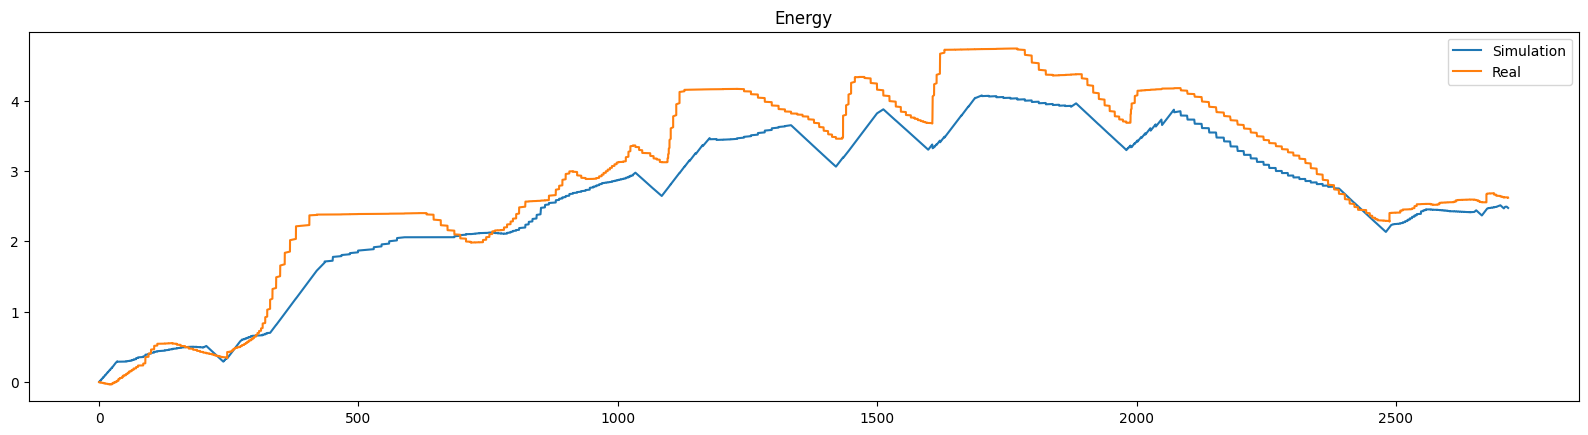

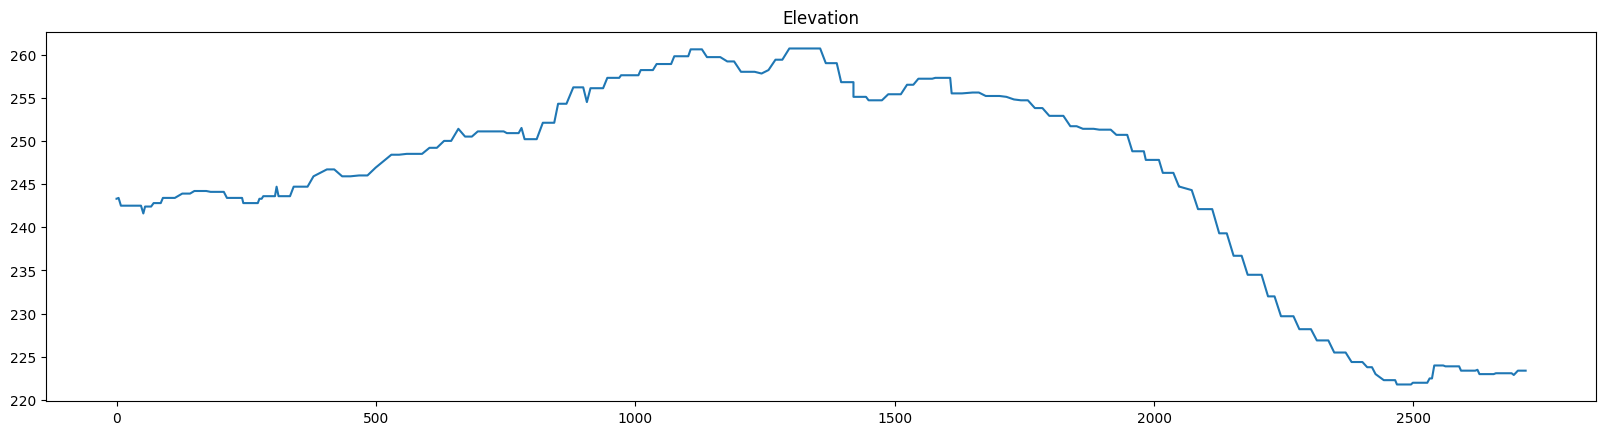

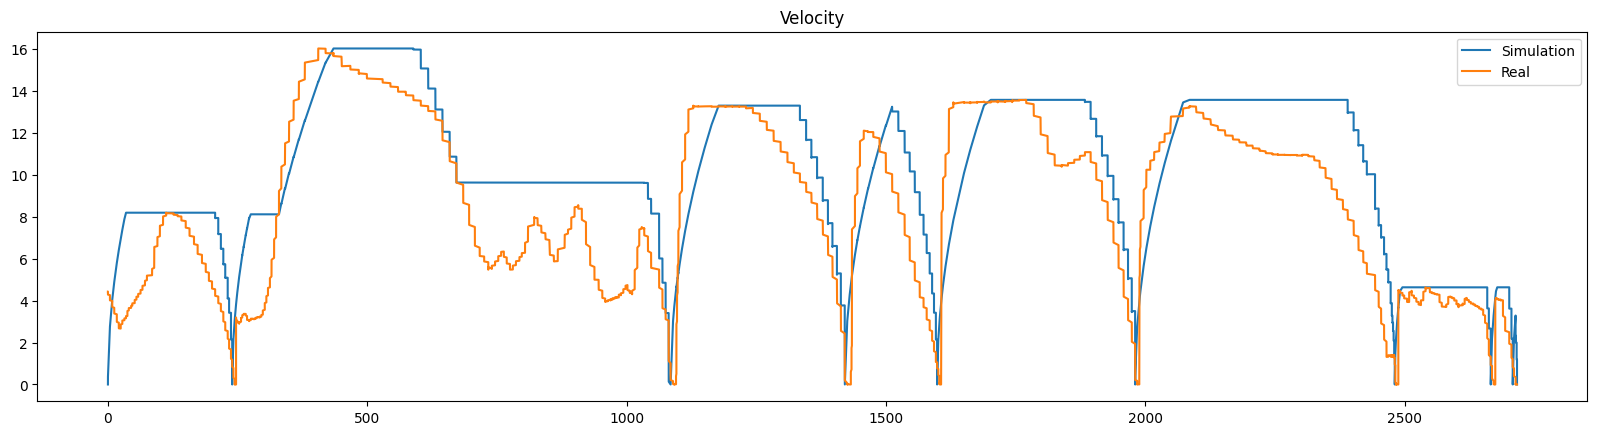

Graphs for data: 02-Vresinska-Zatisi_2022-04-20
Max power from measured data: 598.9970400000001
Simulation final energy: 16.73930753631191
Real final energy: 19.862349672311073


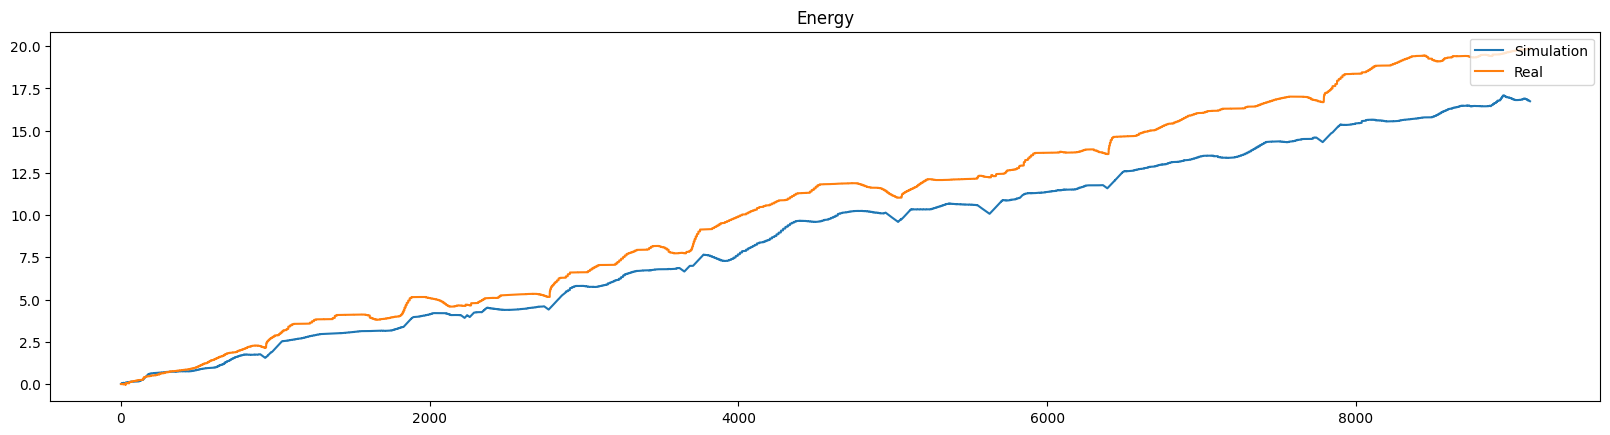

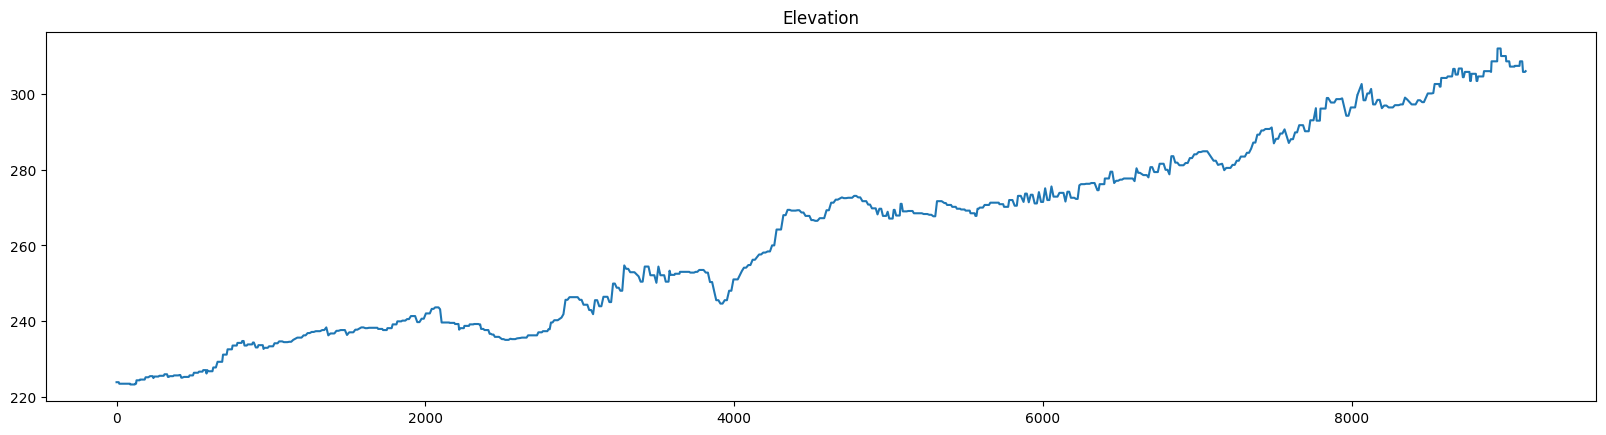

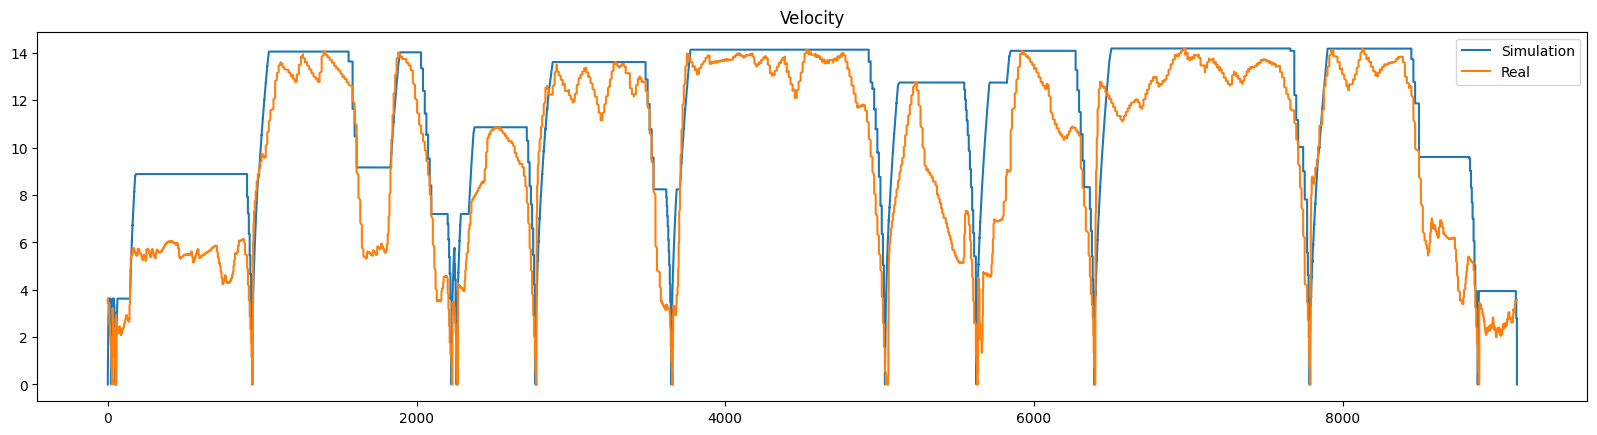

Graphs for data: 03-Zatisi-Vresinska_2022-04-20
Max power from measured data: 654.90727
Simulation final energy: 3.8651200205319896
Real final energy: 6.5903815945083215


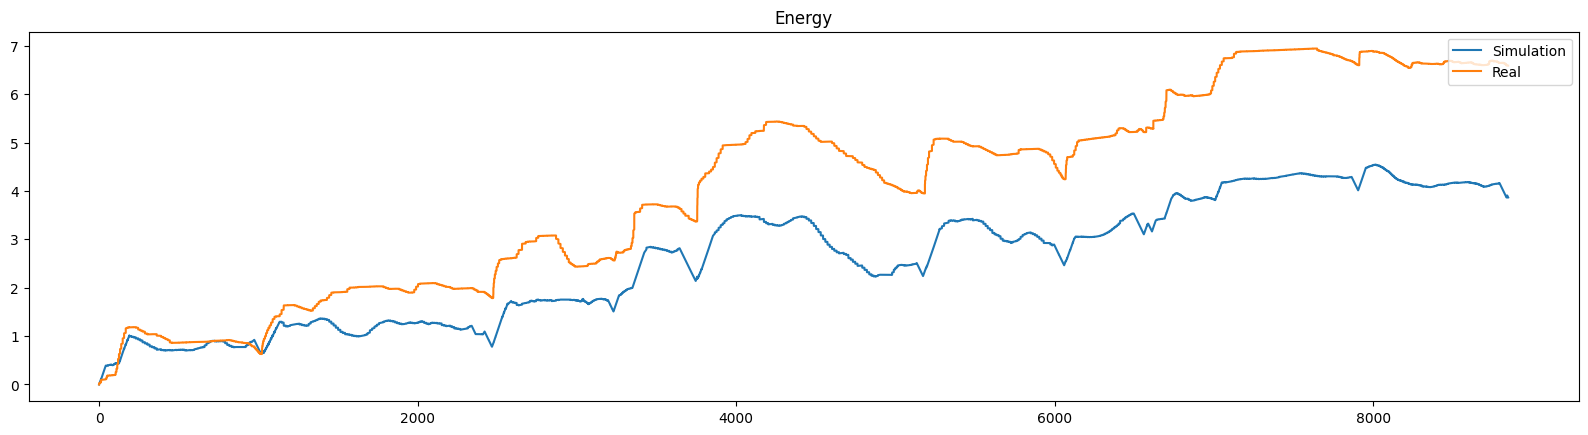

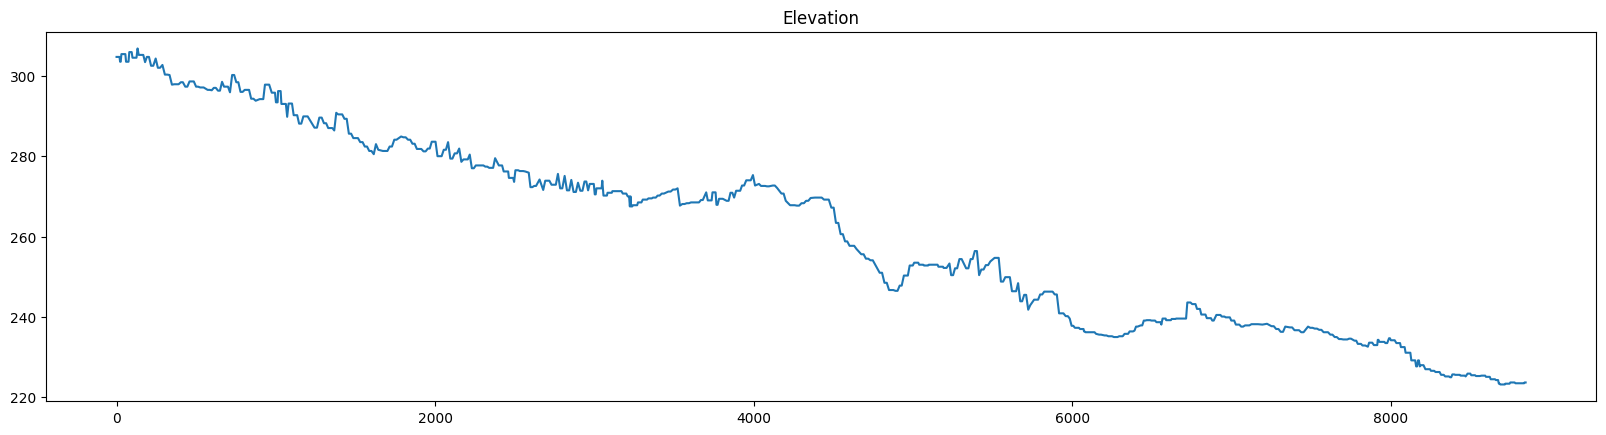

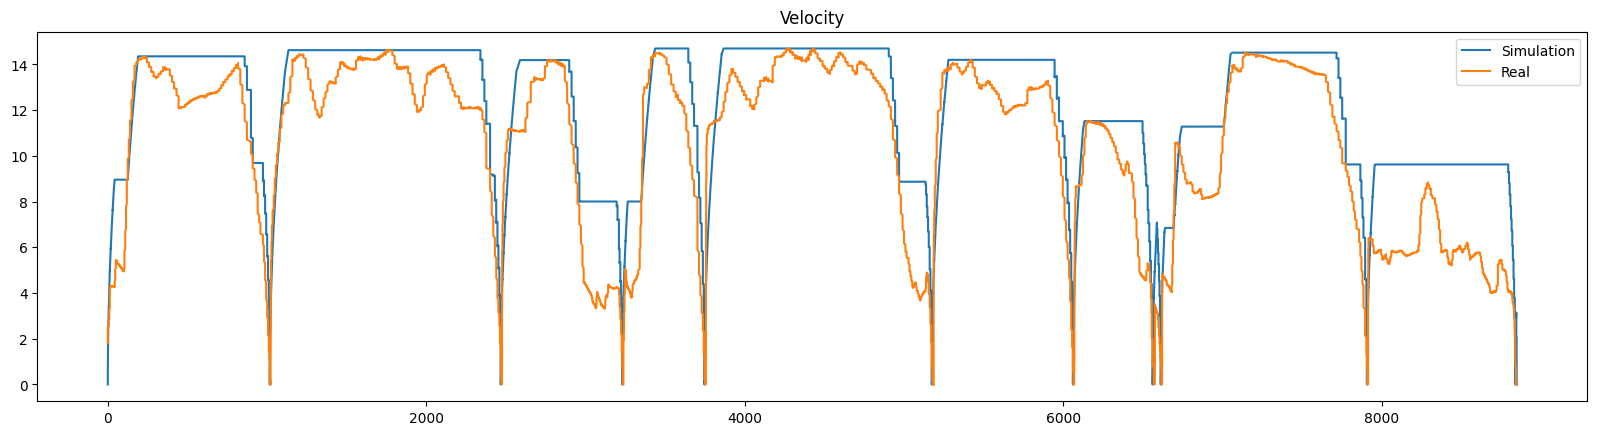

Graphs for data: 1710_02
Max power from measured data: 649.84375
Simulation final energy: 15.75565191945633
Real final energy: 21.020934534003032


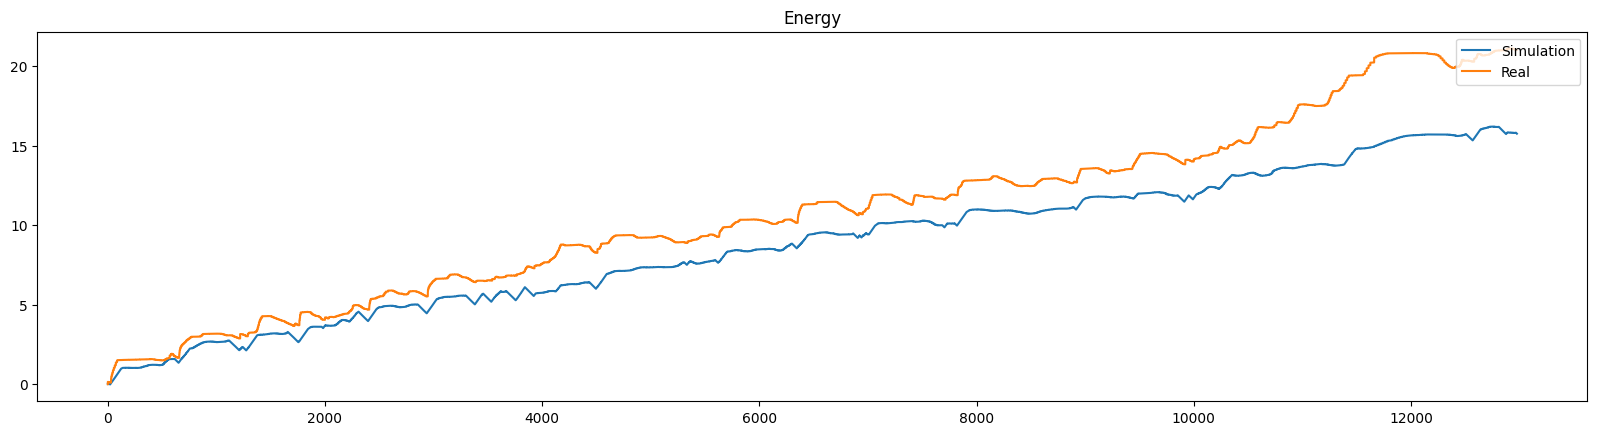

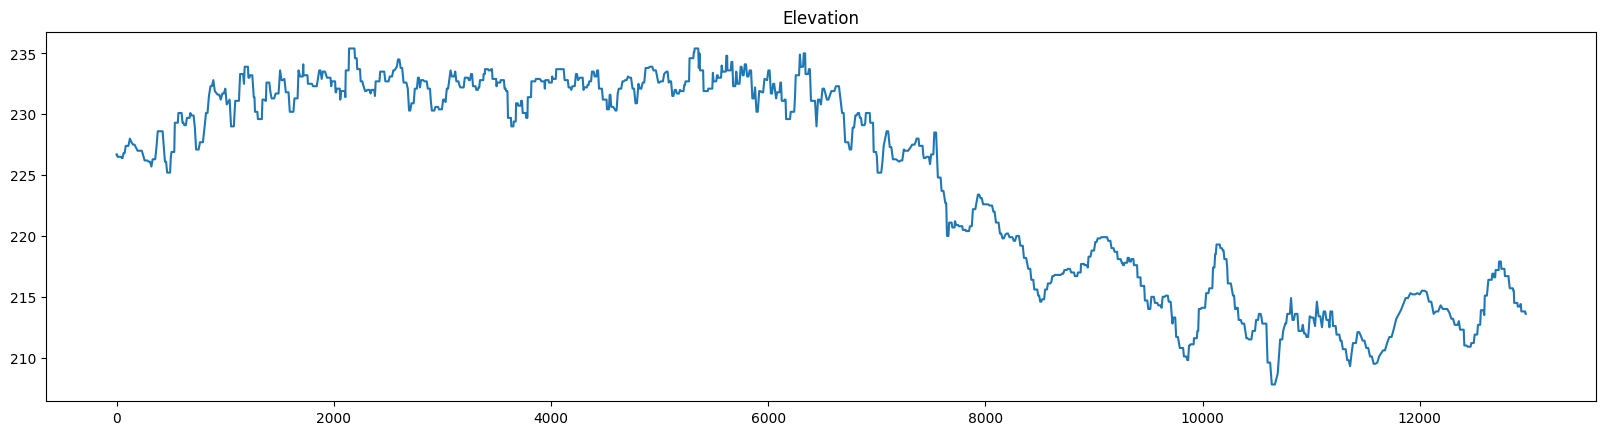

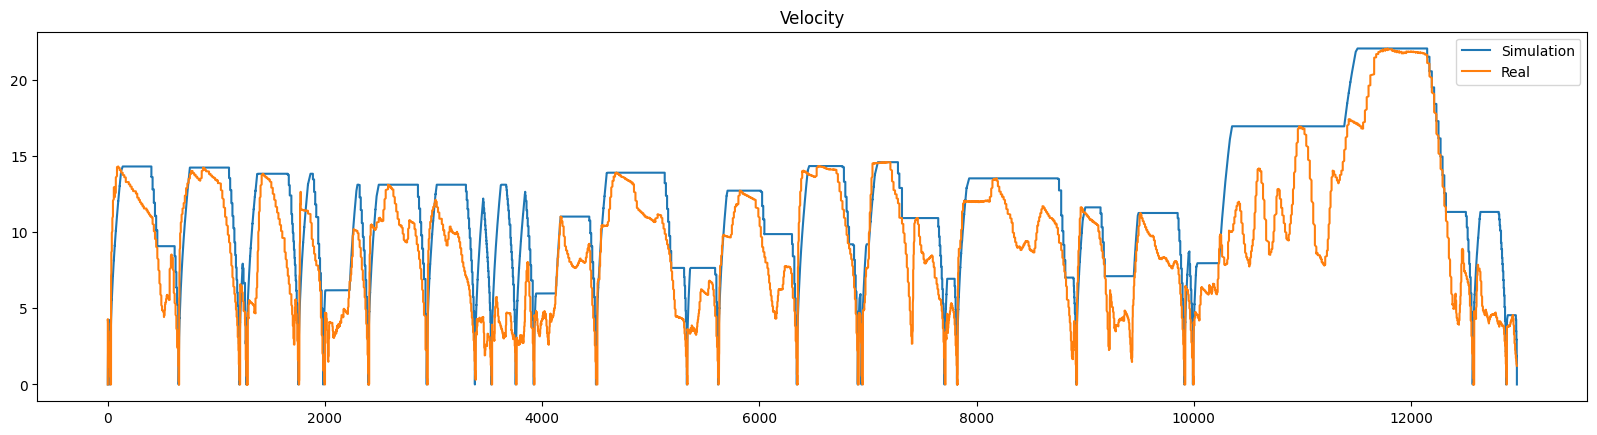

In [8]:
importlib.reload(tconsumption)

# del velocity_segment_cache["01-Vozovna-Vresinska_2022-04-20"]
compare_data(
    DATA_PATH + "DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.csv",
    DATA_PATH + "DPO/Jízda_Poruba_Zátiší_20.04.2022/01-Vozovna-Vresinska_2022-04-20.geojson"
)

compare_data(
    DATA_PATH + "DPO/Jízda_Poruba_Zátiší_20.04.2022/02-Vresinska-Zatisi_2022-04-20.csv",
    DATA_PATH + "DPO/Jízda_Poruba_Zátiší_20.04.2022/02-Vresinska-Zatisi_2022-04-20.geojson"
)

compare_data(
    DATA_PATH + "DPO/Jízda_Poruba_Zátiší_20.04.2022/03-Zatisi-Vresinska_2022-04-20.csv",
    DATA_PATH + "DPO/Jízda_Poruba_Zátiší_20.04.2022/03-Zatisi-Vresinska_2022-04-20.geojson"
)

compare_data(
    DATA_PATH + "DPO/Jizdy_Centrum_07-08-12_07.2022/1710_02.csv",
    DATA_PATH + "DPO/Jizdy_Centrum_07-08-12_07.2022/1710_02.geojson"
)